# [Bacterial Colony Growth](@id Bacteries)

In this example, we are going to create a bacterial model and grow a colony using it.

 - The implementation of the force interaction dynamics is the one presented by [Volfson et al. (2008)](https://www.pnas.org/doi/abs/10.1073/pnas.0706805105)
 - We use GPU accelerated dynamics

As described in other models, it is advised that the models are constructed by parts to avoid having to find bugs in a very complex system. Hence, we will split the model in two parts:

 - Forces model
 - Growth model

## Load the packages

In [1]:
import Pkg

# Activa el entorno del proyecto
Pkg.activate("../")

# Resuelve y asegura dependencias
Pkg.resolve()
Pkg.instantiate()

# Evita errores de versiones incompatibles forzando actualización
Pkg.update(["CairoMakie", "Revise", "CUDA", "Distributions"])

# Carga los paquetes de forma ordenada
using Revise
using CellBasedModels
using CUDA
using Distributions
using CairoMakie

# Importa funciones específicas después
import CairoMakie: Point3f, Cylinder, Sphere, NoShading


  Activating project at `/data/samanthafs/homes/users/jvicens/ABM_CBM`
  No Changes to `/data/samanthafs/homes/users/jvicens/ABM_CBM/Project.toml`
  No Changes to `/data/samanthafs/homes/users/jvicens/ABM_CBM/Manifest.toml`
Precompiling project...
  ✓ OpenSSL_jll
  ✓ NVTX_jll
  ✓ Bzip2_jll
  ✓ Libmount_jll
  ✓ Graphite2_jll
  ✓ x265_jll
  ✓ x264_jll
  ✓ Xorg_libXdmcp_jll
  ✓ Xorg_libXau_jll
  ✓ Rmath_jll
  ✓ IntelOpenMP_jll
  ✓ libpng_jll
  ✓ Pixman_jll
  ✓ oneTBB_jll
  ✓ LLVMExtra_jll
  ✓ Xorg_xtrans_jll
  ✓ Expat_jll
  ✓ libaom_jll
  ✓ CUDA_Driver_jll
  ✓ Xorg_libpthread_stubs_jll
  ✓ LZO_jll
  ✓ FFTW_jll
  ✓ InlineStrings → ParsersExt
  ✓ Libiconv_jll
  ✓ Libuuid_jll
  ✓ FriBidi_jll
  ✓ JuliaNVTXCallbacks_jll
  ✓ OpenSpecFun_jll
  ✓ Sundials_jll
  ✓ FreeType2_jll
  ✓ MKL_jll
  ✓ libsixel_jll
  ✓ Rmath
  ✓ XML2_jll
  ✓ CUDA_Runtime_jll
  ✓ WeakRefStrings
  ✓ Fontconfig_jll
  ✓ NVTX
  ✓ FreeType
  ✓ Gettext_jll
  ✓ XSLT_jll
  ✓ IntervalArithmetic
  ✓ Glib_jll
  ✓ Xorg_libxcb_jll
  ✓ S

## Forces model

We already use the defined forces model that is implemented in CBMModels. This is an exact copy of the rod model that you can find already predefined in `Models/rods.jl`. You can check the `Models` section of the documentation for more details.


In [2]:
rod2D = ABM(2,
    agent = Dict(
            :theta=>Float64,
            :d=>Float64,
            :l=>Float64,
            :fx=>Float64,
            :fy=>Float64,
            :W=>Float64,
            :pressure=>Float64,
            :type=>Int,
        ),    #Local Interaction Parameters

    model = Dict(
            :n=>Int,
            :Ebb=>Float64,
            :Ebg=>Float64,
            :Egg=>Float64,
            :epsbb=>Float64,
            :epsbg=>Float64,
            :epsgg=>Float64,
            :etab=>Float64,
            :etag=>Float64,
        ),        #Global parameters

    agentODE = quote

        fx = 0
        fy = 0
        W = 0
        pressure = 0
        @loopOverNeighbors i2 begin

            #Use the model provided in the documentation
            Fijx, Fijy, Wij = CBMModels.repulsiveForces(x,y,d,l,theta,etab,type, 
                                    x[i2],y[i2],d[i2],l[i2],theta[i2],etag,type[i2], Ebb, Ebg, Egg)

            #Append the repulsive forces
            fx += Fijx
            fy += Fijy
            W += Wij

            #Keep track of preassure in the media
            pressure += sqrt(Fijx^2+Fijy^2)
            #Use the model provided in the documentation
            # Fijx, Fijy, Wij = CBMModels.attractiveForces(x,y,d,l,theta,etab,type, 
            #                         x[i2],y[i2],d[i2],l[i2],theta[i2],etag,type[i2], epsbb, epsbg, epsgg)

            
            
            # #Append the repulsive forces
            # fx += Fijx
            # fy += Fijy
            # W += Wij
            # #Keep track of preassure in the media
            # pressure += sqrt(Fijx^2+Fijy^2)
            
        end

        #Equations
        dt(x) =  fx 
        dt(y) =  fy 
        dt(theta) =  W
    end,

    neighborsAlg=CBMNeighbors.CellLinked(cellEdge=4),
    platform=GPU(),
    agentAlg = CBMIntegrators.Heun()
);


### Initialize a community with two bacteries and check forces

In [ ]:
com = Community(rod2D,
            N=30,
            dt=1.,
            simBox = [-10 10;-10 10.],
            );

#Natural units scales
m = 1.E-12 #ng
t = 1/(60*60) # h
d = 1.E-6 #um


com.n=30
com.Ebb=20. *m/(t^2*d)*1.E-3 #kPa
com.Ebg=100. *m/(t^2*d)*1.E-3 #kPa
com.Egg=100. *m/(t^2*d)*1.E-3 #kPa

com.epsbb=3.E8 *m*d/t^2 #Pa um^2
com.epsbg=28. *m*d/t^2 #Pa um^2
com.epsgg=18. *m*d/t^2 #Pa um^2

com.etab=500 *m/(t*d) #Pa h
com.etag=500 *m/(t*d) #Pa h


1.8000000000000003

In [15]:
com.Ebb, com.epsbb, com.etab

([1.296], [0.003887999999999999], [1.8000000000000003])

In [16]:
for i in 1:com.N
    com.theta[i] = rand() * 2π
    com.x[i] = rand()*16-8
    com.y[i] = rand()*16-8
    if i <= com.n[1]  # agentes del 0 al 4 (long rods)
        com.type[i] = 0
        com.l[i] = 3.0
        com.d[i] = 1.0
    else       # agentes del 5 al 9 (puntos o discos)
        com.type[i] = 1
        com.l[i] = 0
        com.d[i] = 0.8
    end
end

In [17]:
evolve!(com,steps=8000,saveEach=100,preallocateAgents=com.N)

In [18]:
function plotMixedAgents2D!(ax, x, y, d, l, angle, type, p; kargs...)
    for (xi, yi, li, di, ai, ti, pi) in zip(x, y, l, d, angle, type, p)


        if ti== 0  # rods
            colorval = pi
            colormap = :inferno
            meshscatter!(ax,
                [xi + li/2 * cos(ai)],
                [yi + li/2 * sin(ai)];
                marker = Sphere(Point3f(0, 0, 0), Float32(1)),
                markersize = [Point3f(di/2, di/2, di/2)],
                color = [colorval],
                colormap = colormap,
                kargs...
            )
            meshscatter!(ax,
                [xi - li/2 * cos(ai)],
                [yi - li/2 * sin(ai)];
                marker = Sphere(Point3f(0, 0, 0), Float32(1)),
                markersize = [Point3f(di/2, di/2, di/2)],
                color = [colorval],
                colormap = colormap,
                kargs...
            )
            meshscatter!(ax,
                [xi],
                [yi];
                marker = Cylinder(Point3f(-.5, 0, 0), Point3f(.5, 0, 0), Float32(1)),
                markersize = [Point3f(li, di/2, di/2)],
                rotation = [ai],
                color = [colorval],
                colormap = colormap,
                kargs...
            )
        else  # puntos
            colorval = RGBf(0, 1, 1)  # rojo puro
            meshscatter!(ax,
                [Point3f(xi, yi, 0.0)];  # ¡usar coordenadas 3D!
                marker = Sphere(Point3f(0, 0, 0), Float32(1)),
                markersize = [Point3f(di/2, di/2, di/2)],  # ¡tamaño real 3D!
                color = [colorval],
                kargs...
            )
        end

    end
    return
end


plotMixedAgents2D! (generic function with 1 method)

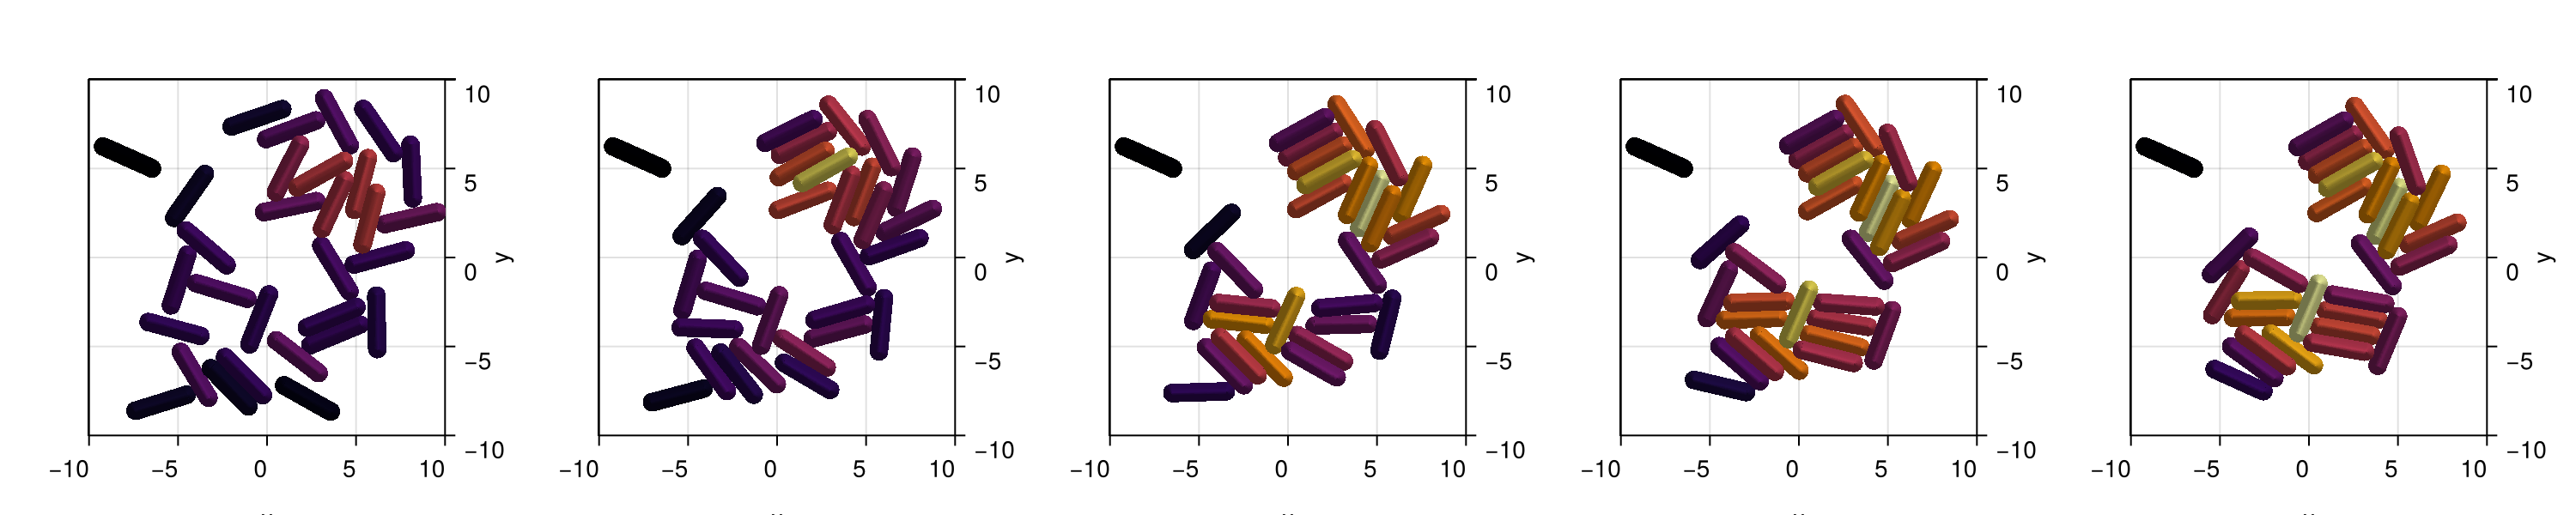

CairoMakie.Screen{IMAGE}


In [19]:
fig = Figure(size=(1500,300))

for (i,j) in enumerate([1:round(Int,length(com)/4):length(com);length(com)])
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )

    plotMixedAgents2D!(
    ax,
    com[j][:x],
    com[j][:y],
    com[j][:d],
    com[j][:l],
    com[j][:theta],
    com[j][:type],
    com[j][:pressure],
    colorrange = (0, maximum(com.pressure))
)
    xlims!(-10,10)
    ylims!(-10,10)
end

display(fig)

## Growth model

We construct over the forces model to add bacterial growth and cell division rules.

In [ ]:
rods2dGrowth = ABM(2,
    baseModelInit = [rod2D],

    agent = Dict(
                :lTarget => Float64,
            ),

    model = Dict(
                :growth=>Float64,
                :σlTarget=>Float64,
                :lMax=>Float64,
                :α=>Float64,
                :σ=>Float64,
                :p_half=>Float64,
            ),

 
    agentODE = quote
        if type == 0
            dt(l) = l*growth/(1+α*pressure) #linear growth with growth dependent on the pressure over the cell
        end
        
    end,

    agentRule = quote #Bound cells
        #Add division
        if l > lTarget
            ww = CBMDistributions.uniform(-.1,.1)/1000 #To add some random torque at division time
            # ww = 0 #To add some random torque at division time
            #Add a new cell
            @addAgent(
                    x=(l+d)/4*cos(theta)+x,
                    y=(l+d)/4*sin(theta)+y,
                    l=(l-d)/2,
                    W=ww,
                    lTarget = CBMDistributions.uniform(lMax-σlTarget,lMax+σlTarget), #New target length at which the bactery should divide
                    type=0)
            #Add a second cell
            @addAgent(
                    x=-(l+d)/4*cos(theta)+x,
                    y=-(l+d)/4*sin(theta)+y,
                    l=(l-d)/2,
                    lTarget = CBMDistributions.uniform(lMax-σlTarget,lMax+σlTarget), #New target length at which the bactery should divide
                    W=ww,
                    type=0)
            #Remove the old cell
            @removeAgent()
        end
        # Probability of releasing PGA with a saturating function
        # prelease = σ * pressure / (p_half + pressure)

        # if CBMDistributions.uniform(0, 1) < prelease
        #     # PGA release!
        #     # You could mark it, count it, or log it here
        #     # @info "PGA released at step $(step) by agent ID $(id)"
        #     aux=CBMDistributions.rand_pm()
        #     @addAgent(
        #             # x=((l+d)*(rand()-1/2)+aux*d/2)*cos(theta)+x,
        #             # y=((l+d)*(rand()-1/2)-aux*d/2)*sin(theta)+y,
        #             x=(CBMDistributions.uniform(-1,1)*(l+d)/2+aux*d/2)*cos(theta)+x,
        #             y=(CBMDistributions.uniform(-1,1)*(l+d)/2-aux*d/2)*sin(theta)+y,
        #             l=0,
        #             d=0.5,
        #             lTarget = CBMDistributions.uniform(lMax-σlTarget,lMax+σlTarget), #New target length at which the bactery should divide
        #             type=1)

        # end


           

    end,

    neighborsAlg=CBMNeighbors.CellLinked(cellEdge=4),
    platform=GPU(),
    agentAlg=CBMIntegrators.Heun()
);

## Grow colony from one cell

In [ ]:
com = Community(rods2dGrowth,
            N=1,
            dt=1.,
            simBox = [-100 100;-100 100.],
            );

#Natural units scales
m = 1.E-12 #ng
t = 1/(60*60) # h
d = 1.E-6 #um


com.n=30
com.Ebb=20. *m/(t^2*d)*1.E-3 #kPa
com.Ebg=100. *m/(t^2*d)*1.E-3 #kPa
com.Egg=100. *m/(t^2*d)*1.E-3 #kPa

com.epsbb=2.E7 *m*d/t^2 #Pa um^2
com.epsbg=18. *m*d/t^2 #Pa um^2
com.epsgg=18. *m*d/t^2 #Pa um^2

com.etab=500 *m/(t*d) #Pa h
com.etag=500 *m/(t*d) #Pa h




com.growth = 0.5 * t
com.lMax = 3.     
com.σlTarget = .2 
com.α = 200
com.σ = 5E-3
com.type=0

com.d = 1.        
com.l = 2.99      
com.lTarget = 3.  

com.p_half=8

com.x = 0
com.y = 0
com.theta = 0;

In [ ]:
evolve!(com,
        steps=200000,saveEach=1000,
        preallocateAgents=20000,
        saveCurrentState=true,
        progressMessage=(com)->if round(Int,com.t/com.dt)%10000 == 0; println("Step: ",round(Int,com.t/com.dt), " N: ", com.N); end)

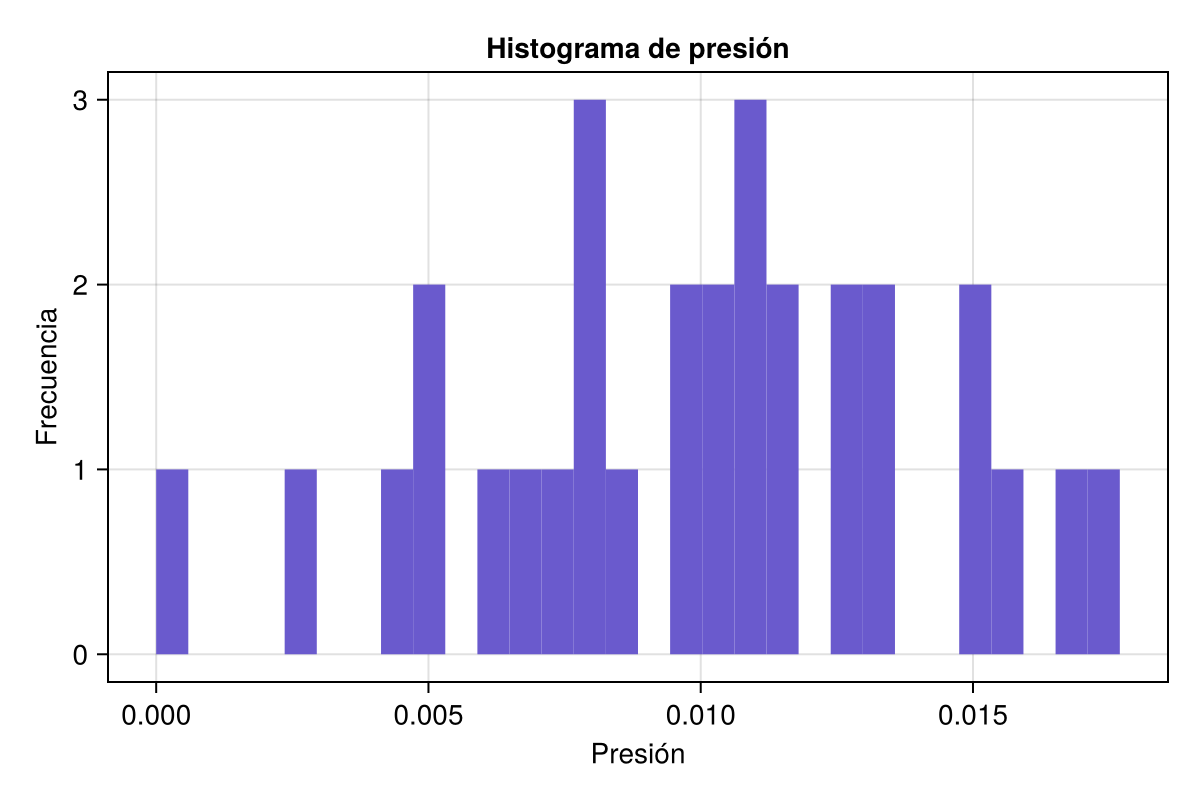

In [22]:
# Elegimos un frame, por ejemplo el último
p = com[end][:pressure]

# Creamos la figura y el eje
fig = Figure(size = (600, 400))
ax = Axis(fig[1, 1]; xlabel = "Presión", ylabel = "Frecuencia", title = "Histograma de presión")

# Dibujamos el histograma
hist!(ax, p; bins = 30, color = :slateblue)

fig  # Esto muestra la figura en una ventana interactiva

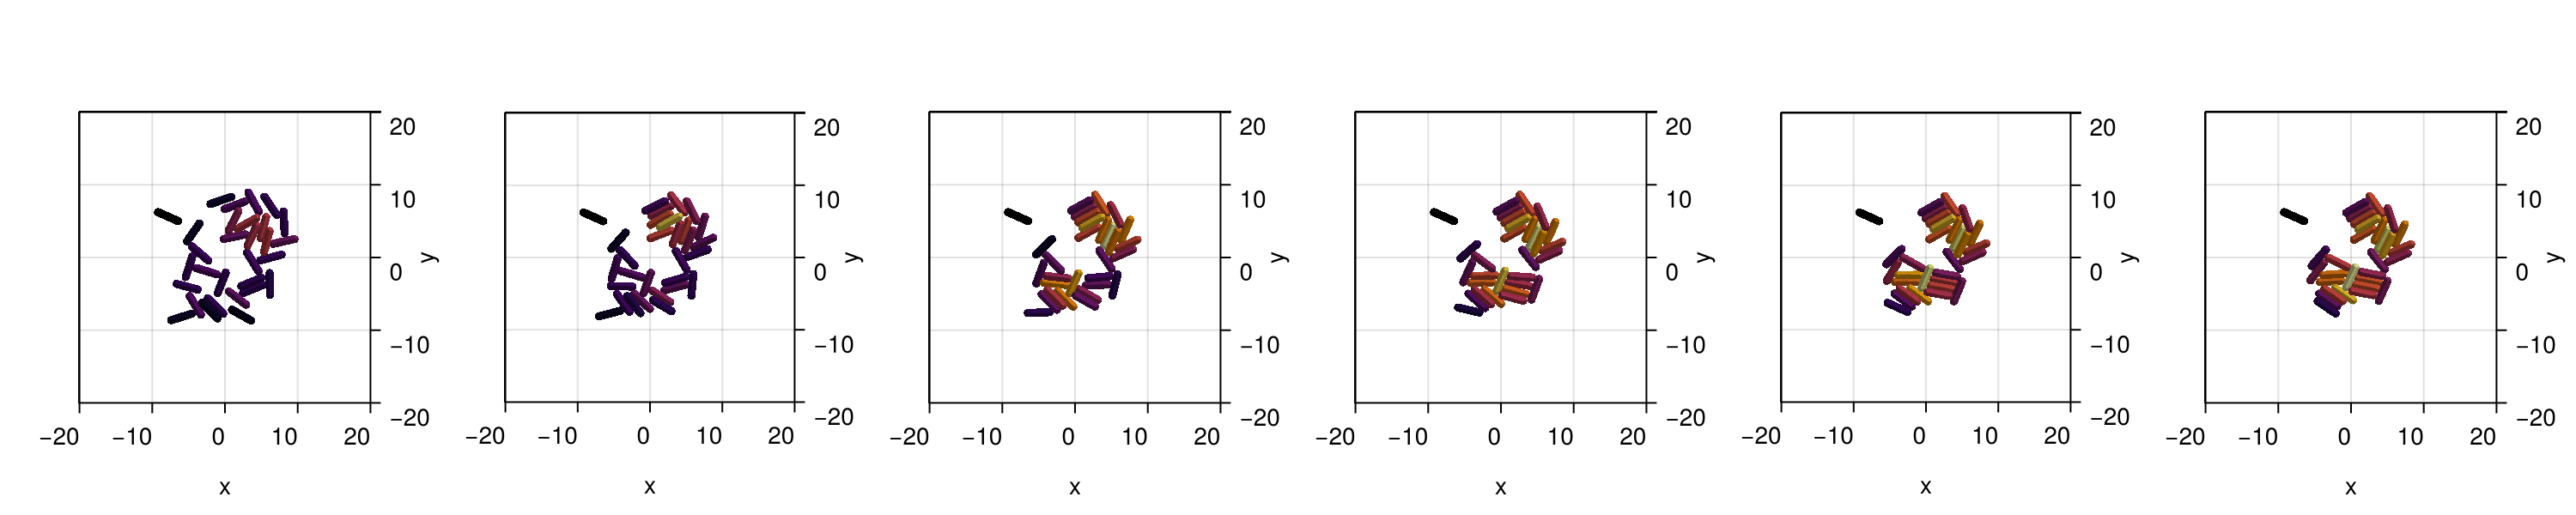

CairoMakie.Screen{IMAGE}


In [23]:
fig = Figure(size=(1500,300))

for (i,j) in enumerate([1:round(Int,length(com)/4):length(com);length(com)])
    ax = Axis3(fig[1,i],
                azimuth=3*π/2,
                elevation=π/2,
                zlabelvisible=false,
                zticklabelsvisible=false,
                zgridvisible=false,
                zspinesvisible=false
            )

    plotMixedAgents2D!(
    ax,
    com[j][:x],
    com[j][:y],
    com[j][:d],
    com[j][:l],
    com[j][:theta],
    com[j][:type],
    com[j][:pressure],
    colorrange = (0, maximum(com.pressure))
    )

    xlims!(-20,20)
    ylims!(-20,20)
end

display(fig)

In [ ]:

fig = Figure(size = (600, 600))
ax = Axis(fig[1, 1]; aspect = DataAspect())

# Cálculo del máximo de presión en todos los frames
max_pressure = maximum(com.pressure)

Makie.record(fig, "bacterias_video_pressure.mp4", 1:length(com); framerate = 15) do j
    # Limpiar el eje
    Makie.empty!(ax)

    # Dibujar los agentes (usando tu función personalizada)
    plotMixedAgents2D!(
        ax,
        com[j][:x],
        com[j][:y],
        com[j][:d],
        com[j][:l],
        com[j][:theta],
        com[j][:type],
        com[j][:pressure],
        colorrange = (0, max_pressure)
    )

    xlims!(ax, -50, 50)
    ylims!(ax, -50, 50)
end


"bacterias_video_pressure_atract_proves.mp4"